In [2]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",50)
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'


C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Training Set

In [3]:
# Load the training set
df = pd.read_csv('training_data/utah_training_set.csv').drop(columns=['fid','index','join_key'],errors='ignore')
df = df.dropna(how='any',axis=0)

In [4]:
df.head()

,timestamp,segment_id,station_id,hour,weekday,month,pre_dir,street_type,suf_dir,one_way,speed_limit,surface_type,surface_width,aadt,sinuosity,euclidean_length,segment_length,near_major_road,road_orient_approx,at_intersection,near_billboard,accident_counts,target,wind_speed,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,icy,hailing,thunderstorm
0,2010-01-01 09:00:00+00:00,21821,72470093141,2,4,1,S,ST,,0,40.0,PAVED,0,2582.0,1.000000,183.940054,183.940054,0,1.548009,1,0,2.0,1,0.0,16093.0,-7.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01 18:00:00+00:00,32221,72470093141,11,4,1,S,,,0,65.0,PAVED,50,2608.0,1.001568,470.656666,471.394576,0,1.728398,0,0,11.0,1,0.0,16093.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-02 09:00:00+00:00,42886,72470093141,2,5,1,E,,,0,65.0,PAVED,50,6644.0,1.028415,3445.573327,3543.478498,0,3.010128,1,0,29.0,1,0.0,16093.0,-13.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-03 01:00:00+00:00,28854,72470093141,18,5,1,W,,,0,65.0,PAVED,0,7849.0,1.004078,1949.083740,1957.032150,0,0.431349,1,0,29.0,1,2.1,16093.0,-11.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-03 15:00:00+00:00,11320,72470093141,8,6,1,E,,,0,65.0,,0,6215.0,1.076797,1983.762463,2136.108683,0,2.192179,1,0,31.0,1,0.0,16093.0,-8.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
ohe_fields=['one_way','surface_type']
df_ohe = pd.get_dummies(df,columns=ohe_fields)
df_ohe.shape

(1971163, 43)

# Continuous Features
These are currently:
* Historical Accident Count
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT (Annual Average Daily Traffic)
* Precipitation Depth
* Snow Depth
* Temperature
* Visibility
* Wind SPeed
* Road Orientation

These will be rescaled by scikit-learn's standard rescaler

In [6]:
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'precip_depth',
    'snow_depth',
    'temperature',
    'visibility',
    'wind_speed'
]
float_features = df_ohe.xs(float_feature_names,axis=1).values

# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)

df_ohe[float_feature_names] = float_scaled

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)


In [7]:
y = df['target'].values
drop_columns = ['index',
                'join_key',
                'segment_id',
                'station_id',
                'timestamp',
                'target',
                'fid',
                'COFIPS',
                'street_type',
                'pre_dir',
                'surface_type',
                'suf_dir']
df_ohe = df_ohe.drop(columns=drop_columns,errors='ignore')

In [8]:
X = df_ohe.values
y = df['target'].values

In [10]:
feature_names = df_ohe.columns.tolist()
print(feature_names)

['hour', 'weekday', 'month', 'speed_limit', 'surface_width', 'aadt', 'sinuosity', 'euclidean_length', 'segment_length', 'near_major_road', 'road_orient_approx', 'at_intersection', 'near_billboard', 'accident_counts', 'wind_speed', 'visibility', 'temperature', 'precip_depth', 'snow_depth', 'snowing', 'raining', 'foggy', 'icy', 'hailing', 'thunderstorm', 'one_way_0', 'one_way_1', 'one_way_2', 'surface_type_ ', 'surface_type_100', 'surface_type_200', 'surface_type_300', 'surface_type_DIRT', 'surface_type_IMPROVED', 'surface_type_OTHER', 'surface_type_PAVED']


In [11]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'drop_columns': drop_columns,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names
}
with open('wrangler.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

# Define Model (Gradient Boosting)

We use XGBoost to build the gradient boosting model

In [12]:
feature_sel = range(len(feature_names))
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]

X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


params = {
    'n_estimators': 200,
    'max_depth':10,
    'min_child_weight': 1.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'objective':'binary:logistic',
}
booster = xgboost.train(params,X_train)


In [13]:
print(fnames)

['hour' 'weekday' 'month' 'speed_limit' 'surface_width' 'aadt' 'sinuosity'
 'euclidean_length' 'segment_length' 'near_major_road' 'road_orient_approx'
 'at_intersection' 'near_billboard' 'accident_counts' 'wind_speed'
 'visibility' 'temperature' 'precip_depth' 'snow_depth' 'snowing' 'raining'
 'foggy' 'icy' 'hailing' 'thunderstorm' 'one_way_0' 'one_way_1' 'one_way_2'
 'surface_type_ ' 'surface_type_100' 'surface_type_200' 'surface_type_300'
 'surface_type_DIRT' 'surface_type_IMPROVED' 'surface_type_OTHER'
 'surface_type_PAVED']


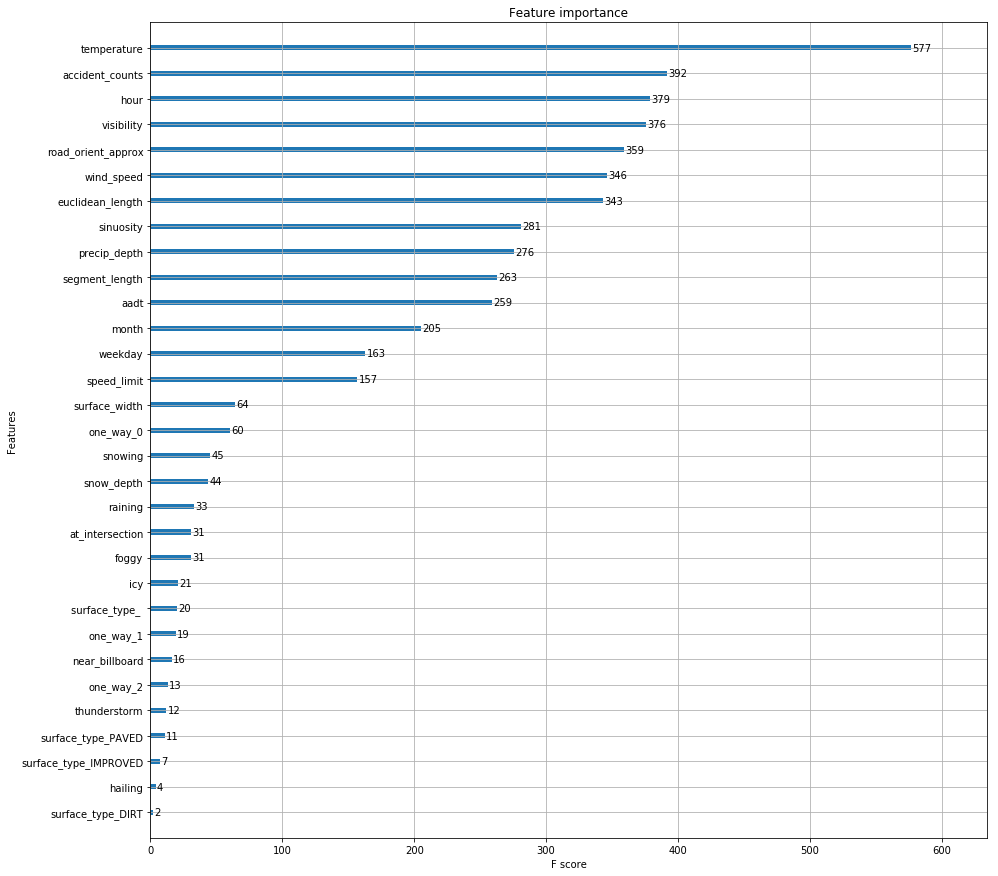

In [14]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [15]:
booster.save_model('0002.model')

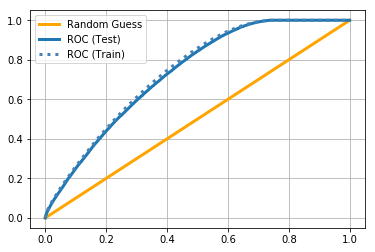

In [16]:
y_pred_test = booster.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.legend()

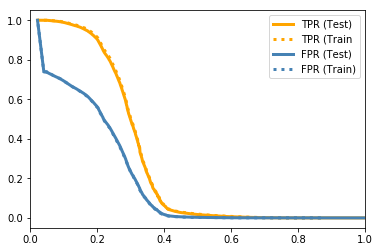

In [17]:

plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.legend()

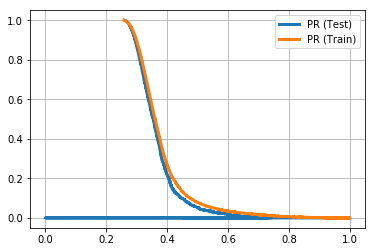

In [18]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(X_test)
y_pred_train = booster.predict(X_train)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)

plt.grid()
plt.legend()

In [19]:
len(X_train.feature_names)

36

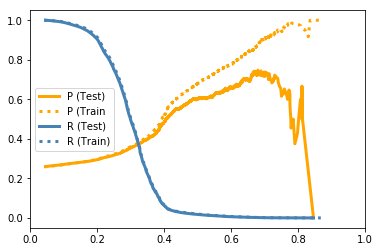

In [20]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.legend()

In [21]:
y_pred_test = booster.predict(X_test) > 0.2
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

y_pred_train = booster.predict(X_train) > 0.2
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

Test Accuracy: 0.533018461117
Test F1: 0.444135798742
Test Precision: 0.294302657799
Test AP: 0.285911571413
Test Recall: 0.904760733178
Test AUC: 0.731029281224
Train Accuracy: 0.537002986394
Train F1: 0.447801972477
Train Precision: 0.296466219091
Test AP: 0.288688205465
Train Recall: 0.914750442206
Train AUC: 0.740079529731
